
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # Qs = qs+ (gamma * nextQs): targetQs is nextQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, targetQs

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_output(actions, next_states, 
                 state_size, action_size, hidden_size):
    # Generator for nextQs as targetQs
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    next_actions_logits, _ = generator(prev_actions=actions_onehot, states=next_states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size)
    
    # # Picking the action with the max logits/value/total rewards
    # nextQs_unmasked = tf.reduce_max(axis=1, input_tensor=next_actions_logits)
    # #print('next_actions_logits.shape, nextQs_unmasked.shape:', next_actions_logits.shape, nextQs_unmasked.shape)
    nextQs_unmasked = next_actions_logits
    
    # Returning nextQs unmasked to be masked and used as targetQs/labels
    return nextQs_unmasked

In [10]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss(prev_actions, states, actions, next_states, targetQs, 
               state_size, action_size, hidden_size):
    # Generator actions and next states
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_fake
    #actions_predictions = tf.nn.softmax(actions_logits)
    nextQs_fake = discriminator(prev_actions=actions_logits, states=next_states_logits,
                                hidden_size=hidden_size)
    
    # Discriminator for nextQs_real
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_real = discriminator(prev_actions=actions_onehot, states=next_states,
                                hidden_size=hidden_size, reuse=True)
    
    # Reshape targetQs from (?,) to (?, 1)
    targetQs = tf.reshape(targetQs, [-1, 1])
    # nextQs_fake = tf.reshape(nextQs_fake, [-1])
    # nextQs_real = tf.reshape(nextQs_real, [-1])
    
    # Adverserial learning/training
    g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.zeros_like(targetQs)))
    g_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake,
                                                                         labels=tf.sigmoid(targetQs)))
    # #g_loss_real = tf.reduce_mean(tf.square(nextQs_real - tf.zeros_like(targetQs)))
    # g_loss_real = tf.reduce_mean(tf.square(nextQs_real))
    # g_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - targetQs))
    g_loss = g_loss_real + g_loss_fake

    # Adverserial learning/training
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.sigmoid(targetQs)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake,
                                                                         labels=tf.zeros_like(targetQs)))
    # d_loss_real = tf.reduce_mean(tf.square(nextQs_real - targetQs))
    # #d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - tf.zeros_like(targetQs)))
    # d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake))
    d_loss = d_loss_real + d_loss_fake
        
    # Returning the D loss
    return actions_logits, g_loss, d_loss

In [11]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss for next state and action prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # action prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.targetQs = model_input(
            state_size=state_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.nextQs_unmasked = model_output(actions=self.actions, next_states=self.next_states, 
                                            state_size=state_size, action_size=action_size, hidden_size=hidden_size)
        
        # NOTE: Qs will be outputed and targetQs are the Qs used as labels
        self.actions_logits, self.g_loss, self.d_loss = model_loss(targetQs=self.targetQs, 
                                                                   prev_actions=self.prev_actions, 
                                                                   states=self.states, actions=self.actions,
                                                                   next_states=self.next_states,
                                                                   state_size=state_size, action_size=action_size, 
                                                                   hidden_size=hidden_size)

        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [15]:
# Training params
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 1000              # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [16]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    #train_episodes = 1 # for debugging
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.actions: actions, model.next_states: next_states}
            nextQs_unmasked = sess.run(model.nextQs_unmasked, feed_dict)
            # print('nextQs_unmasked.shape, dones.shape:', 
            #       nextQs_unmasked.shape, dones.shape)

            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs_unmasked.dtype)).reshape(-1, 1)
            nextQs_masked = np.multiply(nextQs_unmasked, dones_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            # print('dones_mask.shape, nextQs_masked.shape, nextQs.shape:',
            # dones_mask.shape, nextQs_masked.shape, nextQs.shape)
            targetQs = nextQs#.reshape(-1, 1) # model loss calculation against logits
            #print(targetQs.shape)

            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.targetQs: targetQs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 3 Training g_loss: 1.4257 Training d_loss: 1.3876 Explore P: 0.9997
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 24 Training g_loss: 1.2215 Training d_loss: 1.2790 Explore P: 0.9973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 27 Training g_loss: 1.3815 Training d_loss: 0.9764 Explore P: 0.9947
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 26 Training g_loss: 1.3236 Training d_loss: 1.5866 Explore P: 0.9921
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 33 Total reward: 26 Training g_loss: 1.7380 Training d_loss: 1.0978 Explore P: 0.9253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 11 Training g_loss: 1.5037 Training d_loss: 1.3568 Explore P: 0.9243
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 9 Training g_loss: 1.6493 Training d_loss: 1.2976 Explore P: 0.9234
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 14 Training g_loss: 1.7316 Training d_loss: 1.1176 Explore P: 0.9222
-------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 66 Total reward: 16 Training g_loss: 1.6460 Training d_loss: 1.2009 Explore P: 0.8661
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 31 Training g_loss: 1.9718 Training d_loss: 1.1055 Explore P: 0.8635
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 19 Training g_loss: 1.5835 Training d_loss: 1.1965 Explore P: 0.8618
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 18 Training g_loss: 1.4026 Training d_loss: 1.2718 Explore P: 0.8603
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 99 Total reward: 39 Training g_loss: 1.3131 Training d_loss: 1.3114 Explore P: 0.7967
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 100 Total reward: 27 Training g_loss: 1.3131 Training d_loss: 1.2831 Explore P: 0.7946
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 53 Training g_loss: 1.3022 Training d_loss: 1.3193 Explore P: 0.7905
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 16 Training g_loss: 1.2975 Training d_loss: 1.2990 Explore P: 0.7892
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 132 Total reward: 20 Training g_loss: 1.3101 Training d_loss: 1.2845 Explore P: 0.7419
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 133 Total reward: 14 Training g_loss: 1.3242 Training d_loss: 1.2848 Explore P: 0.7408
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 23 Training g_loss: 1.3008 Training d_loss: 1.3394 Explore P: 0.7392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 17 Training g_loss: 1.3131 Training d_loss: 1.3340 Explore P: 0.7379
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 166 Total reward: 34 Training g_loss: 1.2792 Training d_loss: 1.3794 Explore P: 0.6843
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 13 Training g_loss: 1.2604 Training d_loss: 1.3687 Explore P: 0.6834
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 48 Training g_loss: 1.3270 Training d_loss: 1.2894 Explore P: 0.6802
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 18 Training g_loss: 1.3520 Training d_loss: 1.2961 Explore P: 0.6789
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 199 Total reward: 23 Training g_loss: 1.3111 Training d_loss: 1.2913 Explore P: 0.6268
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 200 Total reward: 21 Training g_loss: 1.3205 Training d_loss: 1.2815 Explore P: 0.6255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 17 Training g_loss: 1.3172 Training d_loss: 1.3073 Explore P: 0.6244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 49 Training g_loss: 1.2837 Training d_loss: 1.3554 Explore P: 0.6214
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 232 Total reward: 20 Training g_loss: 1.2988 Training d_loss: 1.3136 Explore P: 0.5712
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 17 Training g_loss: 1.2954 Training d_loss: 1.3100 Explore P: 0.5703
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 18 Training g_loss: 1.2949 Training d_loss: 1.3037 Explore P: 0.5693
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 19 Training g_loss: 1.3001 Training d_loss: 1.2977 Explore P: 0.5682
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 265 Total reward: 22 Training g_loss: 1.3326 Training d_loss: 1.3254 Explore P: 0.5244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 266 Total reward: 48 Training g_loss: 1.2952 Training d_loss: 1.3007 Explore P: 0.5219
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 267 Total reward: 21 Training g_loss: 1.2936 Training d_loss: 1.2990 Explore P: 0.5209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 32 Training g_loss: 1.3297 Training d_loss: 1.3130 Explore P: 0.5192
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 299 Total reward: 12 Training g_loss: 1.7007 Training d_loss: 1.1646 Explore P: 0.4906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 300 Total reward: 13 Training g_loss: 2.0240 Training d_loss: 1.0584 Explore P: 0.4900
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 10 Training g_loss: 2.0774 Training d_loss: 1.0597 Explore P: 0.4895
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 11 Training g_loss: 2.0844 Training d_loss: 1.0705 Explore P: 0.4890
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 333 Total reward: 9 Training g_loss: 1.9227 Training d_loss: 1.0854 Explore P: 0.4716
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 334 Total reward: 12 Training g_loss: 1.9053 Training d_loss: 1.1127 Explore P: 0.4711
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 335 Total reward: 13 Training g_loss: 1.8136 Training d_loss: 1.1681 Explore P: 0.4705
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 336 Total reward: 9 Training g_loss: 1.7854 Training d_loss: 1.1716 Explore P: 0.4701
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 366 Total reward: 11 Training g_loss: 1.8446 Training d_loss: 1.1333 Explore P: 0.4531
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 367 Total reward: 10 Training g_loss: 1.8464 Training d_loss: 1.1246 Explore P: 0.4526
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 15 Training g_loss: 1.8091 Training d_loss: 1.1411 Explore P: 0.4520
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 12 Training g_loss: 1.8489 Training d_loss: 1.1214 Explore P: 0.4514
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 399 Total reward: 13 Training g_loss: 1.8220 Training d_loss: 1.1414 Explore P: 0.4327
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 400 Total reward: 11 Training g_loss: 1.8293 Training d_loss: 1.1348 Explore P: 0.4323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 401 Total reward: 9 Training g_loss: 1.8105 Training d_loss: 1.1389 Explore P: 0.4319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 402 Total reward: 14 Training g_loss: 1.8061 Training d_loss: 1.1389 Explore P: 0.4313
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 432 Total reward: 17 Training g_loss: 1.9383 Training d_loss: 1.1173 Explore P: 0.4153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 433 Total reward: 17 Training g_loss: 1.8224 Training d_loss: 1.1295 Explore P: 0.4146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 434 Total reward: 13 Training g_loss: 1.7843 Training d_loss: 1.1331 Explore P: 0.4141
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 435 Total reward: 9 Training g_loss: 1.7958 Training d_loss: 1.1434 Explore P: 0.4137
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 465 Total reward: 15 Training g_loss: 1.8005 Training d_loss: 1.1716 Explore P: 0.3994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 466 Total reward: 12 Training g_loss: 1.9175 Training d_loss: 1.1199 Explore P: 0.3989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 467 Total reward: 10 Training g_loss: 1.9159 Training d_loss: 1.1229 Explore P: 0.3985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 468 Total reward: 14 Training g_loss: 1.8345 Training d_loss: 1.1395 Explore P: 0.3980
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 498 Total reward: 15 Training g_loss: 1.7124 Training d_loss: 1.1534 Explore P: 0.3838
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 499 Total reward: 12 Training g_loss: 1.7254 Training d_loss: 1.1435 Explore P: 0.3834
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 500 Total reward: 8 Training g_loss: 1.7521 Training d_loss: 1.1440 Explore P: 0.3831
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 501 Total reward: 15 Training g_loss: 1.8042 Training d_loss: 1.1445 Explore P: 0.3825
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 531 Total reward: 8 Training g_loss: 1.8179 Training d_loss: 1.2180 Explore P: 0.3690
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 532 Total reward: 13 Training g_loss: 1.8460 Training d_loss: 1.1219 Explore P: 0.3685
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 10 Training g_loss: 2.0190 Training d_loss: 1.0529 Explore P: 0.3682
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 17 Training g_loss: 1.8294 Training d_loss: 1.1826 Explore P: 0.3676
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 564 Total reward: 18 Training g_loss: 1.9771 Training d_loss: 1.0704 Explore P: 0.3553
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 565 Total reward: 10 Training g_loss: 1.9203 Training d_loss: 1.1221 Explore P: 0.3550
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 566 Total reward: 9 Training g_loss: 1.8200 Training d_loss: 1.2005 Explore P: 0.3546
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 8 Training g_loss: 1.7136 Training d_loss: 1.2653 Explore P: 0.3544
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 598 Total reward: 12 Training g_loss: 1.7321 Training d_loss: 1.1728 Explore P: 0.3421
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 599 Total reward: 11 Training g_loss: 1.7255 Training d_loss: 1.1795 Explore P: 0.3417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 600 Total reward: 17 Training g_loss: 1.7222 Training d_loss: 1.1670 Explore P: 0.3411
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 601 Total reward: 8 Training g_loss: 1.7201 Training d_loss: 1.1665 Explore P: 0.3409
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 631 Total reward: 14 Training g_loss: 1.6931 Training d_loss: 1.1562 Explore P: 0.3298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 632 Total reward: 10 Training g_loss: 1.6910 Training d_loss: 1.1529 Explore P: 0.3295
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 633 Total reward: 10 Training g_loss: 1.7454 Training d_loss: 1.1336 Explore P: 0.3292
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 634 Total reward: 12 Training g_loss: 1.7543 Training d_loss: 1.1520 Explore P: 0.3288
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 664 Total reward: 11 Training g_loss: 1.7755 Training d_loss: 1.1659 Explore P: 0.3171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 665 Total reward: 13 Training g_loss: 1.7988 Training d_loss: 1.1619 Explore P: 0.3167
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 666 Total reward: 14 Training g_loss: 1.7368 Training d_loss: 1.1899 Explore P: 0.3163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 667 Total reward: 14 Training g_loss: 1.7423 Training d_loss: 1.1849 Explore P: 0.3159
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 697 Total reward: 14 Training g_loss: 1.6788 Training d_loss: 1.1988 Explore P: 0.3052
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 698 Total reward: 23 Training g_loss: 1.7397 Training d_loss: 1.1945 Explore P: 0.3045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 699 Total reward: 19 Training g_loss: 1.8552 Training d_loss: 1.1444 Explore P: 0.3039
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 700 Total reward: 11 Training g_loss: 1.9218 Training d_loss: 1.1213 Explore P: 0.3036
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 731 Total reward: 13 Training g_loss: 1.6742 Training d_loss: 1.1527 Explore P: 0.2934
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 732 Total reward: 16 Training g_loss: 1.7710 Training d_loss: 1.1188 Explore P: 0.2929
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 733 Total reward: 7 Training g_loss: 1.7939 Training d_loss: 1.1355 Explore P: 0.2927
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 734 Total reward: 10 Training g_loss: 1.8037 Training d_loss: 1.1517 Explore P: 0.2924
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 764 Total reward: 10 Training g_loss: 1.8235 Training d_loss: 1.0974 Explore P: 0.2811
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 765 Total reward: 17 Training g_loss: 1.4593 Training d_loss: 1.2596 Explore P: 0.2807
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 766 Total reward: 12 Training g_loss: 1.3284 Training d_loss: 1.3270 Explore P: 0.2803
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 767 Total reward: 20 Training g_loss: 1.6786 Training d_loss: 1.1870 Explore P: 0.2798
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 798 Total reward: 10 Training g_loss: 1.6345 Training d_loss: 1.1784 Explore P: 0.2702
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 799 Total reward: 10 Training g_loss: 1.6992 Training d_loss: 1.1098 Explore P: 0.2700
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 800 Total reward: 16 Training g_loss: 1.6719 Training d_loss: 1.1874 Explore P: 0.2696
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 801 Total reward: 11 Training g_loss: 1.6335 Training d_loss: 1.2747 Explore P: 0.2693
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 832 Total reward: 9 Training g_loss: 1.6596 Training d_loss: 1.2031 Explore P: 0.2601
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 833 Total reward: 10 Training g_loss: 1.6043 Training d_loss: 1.2437 Explore P: 0.2598
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 834 Total reward: 14 Training g_loss: 1.6793 Training d_loss: 1.2061 Explore P: 0.2595
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 835 Total reward: 10 Training g_loss: 1.7122 Training d_loss: 1.1660 Explore P: 0.2592
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 866 Total reward: 13 Training g_loss: 1.6934 Training d_loss: 1.1802 Explore P: 0.2498
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 867 Total reward: 14 Training g_loss: 1.6802 Training d_loss: 1.1866 Explore P: 0.2495
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 868 Total reward: 9 Training g_loss: 1.6245 Training d_loss: 1.2086 Explore P: 0.2493
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 869 Total reward: 17 Training g_loss: 1.6371 Training d_loss: 1.1917 Explore P: 0.2489
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 899 Total reward: 11 Training g_loss: 1.7149 Training d_loss: 1.1813 Explore P: 0.2414
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 900 Total reward: 9 Training g_loss: 1.7222 Training d_loss: 1.1633 Explore P: 0.2412
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 901 Total reward: 12 Training g_loss: 1.6983 Training d_loss: 1.1780 Explore P: 0.2409
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 902 Total reward: 8 Training g_loss: 1.6849 Training d_loss: 1.1833 Explore P: 0.2407
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 932 Total reward: 13 Training g_loss: 1.6346 Training d_loss: 1.1727 Explore P: 0.2331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 933 Total reward: 18 Training g_loss: 1.6357 Training d_loss: 1.1716 Explore P: 0.2327
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 934 Total reward: 10 Training g_loss: 1.6180 Training d_loss: 1.1872 Explore P: 0.2325
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 935 Total reward: 12 Training g_loss: 1.6475 Training d_loss: 1.1913 Explore P: 0.2322
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 965 Total reward: 14 Training g_loss: 1.7098 Training d_loss: 1.1294 Explore P: 0.2254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 966 Total reward: 9 Training g_loss: 1.7301 Training d_loss: 1.1212 Explore P: 0.2252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 967 Total reward: 8 Training g_loss: 1.7175 Training d_loss: 1.1403 Explore P: 0.2251
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 968 Total reward: 11 Training g_loss: 1.6938 Training d_loss: 1.1593 Explore P: 0.2248
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 999 Total reward: 7 Training g_loss: 1.6857 Training d_loss: 1.1805 Explore P: 0.2179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1000 Total reward: 11 Training g_loss: 1.6654 Training d_loss: 1.1805 Explore P: 0.2177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1001 Total reward: 12 Training g_loss: 1.6512 Training d_loss: 1.1861 Explore P: 0.2174
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1002 Total reward: 10 Training g_loss: 1.6156 Training d_loss: 1.2058 Explore P: 0.2172
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1031 Total reward: 13 Training g_loss: 1.6423 Training d_loss: 1.2123 Explore P: 0.2110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1032 Total reward: 10 Training g_loss: 1.6549 Training d_loss: 1.2144 Explore P: 0.2108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1033 Total reward: 7 Training g_loss: 1.6541 Training d_loss: 1.2048 Explore P: 0.2107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1034 Total reward: 10 Training g_loss: 1.6939 Training d_loss: 1.1856 Explore P: 0.2105
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1064 Total reward: 12 Training g_loss: 1.6357 Training d_loss: 1.1853 Explore P: 0.2039
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1065 Total reward: 15 Training g_loss: 1.6142 Training d_loss: 1.1919 Explore P: 0.2036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1066 Total reward: 12 Training g_loss: 1.6308 Training d_loss: 1.1869 Explore P: 0.2034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1067 Total reward: 15 Training g_loss: 1.6132 Training d_loss: 1.1993 Explore P: 0.2031
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1097 Total reward: 12 Training g_loss: 1.6489 Training d_loss: 1.2011 Explore P: 0.1972
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1098 Total reward: 12 Training g_loss: 1.6333 Training d_loss: 1.2011 Explore P: 0.1970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1099 Total reward: 9 Training g_loss: 1.6221 Training d_loss: 1.2029 Explore P: 0.1968
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1100 Total reward: 8 Training g_loss: 1.6653 Training d_loss: 1.1842 Explore P: 0.1967
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1130 Total reward: 16 Training g_loss: 1.6072 Training d_loss: 1.1838 Explore P: 0.1911
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1131 Total reward: 8 Training g_loss: 1.6092 Training d_loss: 1.2103 Explore P: 0.1910
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1132 Total reward: 11 Training g_loss: 1.6031 Training d_loss: 1.2430 Explore P: 0.1908
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1133 Total reward: 8 Training g_loss: 1.5981 Training d_loss: 1.2550 Explore P: 0.1906
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1162 Total reward: 8 Training g_loss: 1.5840 Training d_loss: 1.1855 Explore P: 0.1853
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1163 Total reward: 10 Training g_loss: 1.5491 Training d_loss: 1.2252 Explore P: 0.1851
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1164 Total reward: 8 Training g_loss: 1.5821 Training d_loss: 1.2192 Explore P: 0.1850
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1165 Total reward: 11 Training g_loss: 1.5579 Training d_loss: 1.3039 Explore P: 0.1848
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1195 Total reward: 15 Training g_loss: 1.5989 Training d_loss: 1.2231 Explore P: 0.1792
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1196 Total reward: 10 Training g_loss: 1.6169 Training d_loss: 1.2110 Explore P: 0.1791
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1197 Total reward: 9 Training g_loss: 1.6201 Training d_loss: 1.2042 Explore P: 0.1789
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1198 Total reward: 10 Training g_loss: 1.6576 Training d_loss: 1.1870 Explore P: 0.1787
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1227 Total reward: 11 Training g_loss: 1.6108 Training d_loss: 1.2032 Explore P: 0.1736
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1228 Total reward: 10 Training g_loss: 1.6171 Training d_loss: 1.2040 Explore P: 0.1734
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1229 Total reward: 11 Training g_loss: 1.6182 Training d_loss: 1.2022 Explore P: 0.1732
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1230 Total reward: 11 Training g_loss: 1.6238 Training d_loss: 1.2005 Explore P: 0.1730
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1259 Total reward: 17 Training g_loss: 1.6000 Training d_loss: 1.2104 Explore P: 0.1681
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1260 Total reward: 7 Training g_loss: 1.5858 Training d_loss: 1.2130 Explore P: 0.1680
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1261 Total reward: 8 Training g_loss: 1.5859 Training d_loss: 1.2089 Explore P: 0.1679
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1262 Total reward: 11 Training g_loss: 1.5878 Training d_loss: 1.2052 Explore P: 0.1677
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1292 Total reward: 10 Training g_loss: 1.5771 Training d_loss: 1.2077 Explore P: 0.1628
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1293 Total reward: 10 Training g_loss: 1.5811 Training d_loss: 1.2045 Explore P: 0.1627
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1294 Total reward: 10 Training g_loss: 1.5752 Training d_loss: 1.2066 Explore P: 0.1625
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1295 Total reward: 9 Training g_loss: 1.6138 Training d_loss: 1.1964 Explore P: 0.1624
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1324 Total reward: 12 Training g_loss: 1.6521 Training d_loss: 1.1981 Explore P: 0.1576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1325 Total reward: 10 Training g_loss: 1.6286 Training d_loss: 1.2108 Explore P: 0.1574
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1326 Total reward: 13 Training g_loss: 1.6295 Training d_loss: 1.2087 Explore P: 0.1572
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1327 Total reward: 10 Training g_loss: 1.6072 Training d_loss: 1.2157 Explore P: 0.1571
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1356 Total reward: 8 Training g_loss: 1.5859 Training d_loss: 1.2195 Explore P: 0.1529
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1357 Total reward: 11 Training g_loss: 1.5890 Training d_loss: 1.2370 Explore P: 0.1528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1358 Total reward: 9 Training g_loss: 1.6313 Training d_loss: 1.2367 Explore P: 0.1526
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1359 Total reward: 10 Training g_loss: 1.7009 Training d_loss: 1.2332 Explore P: 0.1525
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1389 Total reward: 7 Training g_loss: 1.5563 Training d_loss: 1.2514 Explore P: 0.1482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1390 Total reward: 9 Training g_loss: 1.5474 Training d_loss: 1.2235 Explore P: 0.1480
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1391 Total reward: 8 Training g_loss: 1.7063 Training d_loss: 1.1928 Explore P: 0.1479
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1392 Total reward: 13 Training g_loss: 1.6219 Training d_loss: 1.2260 Explore P: 0.1478
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1421 Total reward: 13 Training g_loss: 1.5972 Training d_loss: 1.2108 Explore P: 0.1438
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1422 Total reward: 11 Training g_loss: 1.6311 Training d_loss: 1.2062 Explore P: 0.1436
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1423 Total reward: 10 Training g_loss: 1.6218 Training d_loss: 1.2144 Explore P: 0.1435
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1424 Total reward: 10 Training g_loss: 1.6304 Training d_loss: 1.2117 Explore P: 0.1433
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1453 Total reward: 10 Training g_loss: 1.6264 Training d_loss: 1.2054 Explore P: 0.1395
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1454 Total reward: 8 Training g_loss: 1.6628 Training d_loss: 1.1900 Explore P: 0.1394
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1455 Total reward: 10 Training g_loss: 1.6546 Training d_loss: 1.1989 Explore P: 0.1393
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1456 Total reward: 9 Training g_loss: 1.6530 Training d_loss: 1.2220 Explore P: 0.1392
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1485 Total reward: 12 Training g_loss: 1.6932 Training d_loss: 1.2137 Explore P: 0.1352
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1486 Total reward: 10 Training g_loss: 1.5778 Training d_loss: 1.3259 Explore P: 0.1351
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1487 Total reward: 9 Training g_loss: 1.5412 Training d_loss: 1.2836 Explore P: 0.1350
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1488 Total reward: 9 Training g_loss: 1.5412 Training d_loss: 1.2490 Explore P: 0.1349
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1517 Total reward: 9 Training g_loss: 1.5507 Training d_loss: 1.2165 Explore P: 0.1315
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1518 Total reward: 14 Training g_loss: 1.5637 Training d_loss: 1.1985 Explore P: 0.1313
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1519 Total reward: 9 Training g_loss: 1.5729 Training d_loss: 1.2077 Explore P: 0.1312
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1520 Total reward: 10 Training g_loss: 1.5864 Training d_loss: 1.2237 Explore P: 0.1311
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1550 Total reward: 8 Training g_loss: 1.5681 Training d_loss: 1.2161 Explore P: 0.1276
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1551 Total reward: 14 Training g_loss: 1.6242 Training d_loss: 1.1940 Explore P: 0.1274
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1552 Total reward: 11 Training g_loss: 1.6206 Training d_loss: 1.1972 Explore P: 0.1273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1553 Total reward: 10 Training g_loss: 1.6211 Training d_loss: 1.2090 Explore P: 0.1272
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1582 Total reward: 11 Training g_loss: 1.5966 Training d_loss: 1.2213 Explore P: 0.1238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1583 Total reward: 9 Training g_loss: 1.5809 Training d_loss: 1.2300 Explore P: 0.1236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1584 Total reward: 12 Training g_loss: 1.6137 Training d_loss: 1.2177 Explore P: 0.1235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1585 Total reward: 9 Training g_loss: 1.6238 Training d_loss: 1.2124 Explore P: 0.1234
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1614 Total reward: 17 Training g_loss: 1.5623 Training d_loss: 1.2152 Explore P: 0.1200
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1615 Total reward: 7 Training g_loss: 1.5696 Training d_loss: 1.2135 Explore P: 0.1199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1616 Total reward: 9 Training g_loss: 1.5647 Training d_loss: 1.2194 Explore P: 0.1198
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1617 Total reward: 10 Training g_loss: 1.5632 Training d_loss: 1.2218 Explore P: 0.1197
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1647 Total reward: 10 Training g_loss: 1.5870 Training d_loss: 1.2139 Explore P: 0.1164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1648 Total reward: 8 Training g_loss: 1.5962 Training d_loss: 1.2214 Explore P: 0.1163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1649 Total reward: 9 Training g_loss: 1.5873 Training d_loss: 1.2208 Explore P: 0.1162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1650 Total reward: 8 Training g_loss: 1.5856 Training d_loss: 1.2149 Explore P: 0.1161
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1679 Total reward: 11 Training g_loss: 1.5762 Training d_loss: 1.1900 Explore P: 0.1130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1680 Total reward: 8 Training g_loss: 1.5638 Training d_loss: 1.2024 Explore P: 0.1130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1681 Total reward: 9 Training g_loss: 1.5789 Training d_loss: 1.2075 Explore P: 0.1129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1682 Total reward: 16 Training g_loss: 1.5827 Training d_loss: 1.2264 Explore P: 0.1127
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1712 Total reward: 12 Training g_loss: 1.5456 Training d_loss: 1.2587 Explore P: 0.1097
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1713 Total reward: 20 Training g_loss: 1.7267 Training d_loss: 1.0890 Explore P: 0.1095
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1714 Total reward: 9 Training g_loss: 1.7957 Training d_loss: 1.1290 Explore P: 0.1094
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1715 Total reward: 8 Training g_loss: 1.7133 Training d_loss: 1.1906 Explore P: 0.1093
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1745 Total reward: 11 Training g_loss: 1.5878 Training d_loss: 1.1724 Explore P: 0.1063
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1746 Total reward: 12 Training g_loss: 1.5857 Training d_loss: 1.1765 Explore P: 0.1062
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1747 Total reward: 9 Training g_loss: 1.5776 Training d_loss: 1.1998 Explore P: 0.1061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1748 Total reward: 8 Training g_loss: 1.5481 Training d_loss: 1.2417 Explore P: 0.1060
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1777 Total reward: 10 Training g_loss: 1.5048 Training d_loss: 1.2216 Explore P: 0.1031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1778 Total reward: 8 Training g_loss: 1.5158 Training d_loss: 1.2202 Explore P: 0.1030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1779 Total reward: 10 Training g_loss: 1.5246 Training d_loss: 1.2159 Explore P: 0.1030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1780 Total reward: 10 Training g_loss: 1.5403 Training d_loss: 1.2107 Explore P: 0.1029
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1809 Total reward: 7 Training g_loss: 1.5568 Training d_loss: 1.2219 Explore P: 0.1000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1810 Total reward: 10 Training g_loss: 1.5424 Training d_loss: 1.2309 Explore P: 0.1000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1811 Total reward: 12 Training g_loss: 1.5618 Training d_loss: 1.2338 Explore P: 0.0998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1812 Total reward: 10 Training g_loss: 1.5513 Training d_loss: 1.2419 Explore P: 0.0998
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1842 Total reward: 7 Training g_loss: 1.5556 Training d_loss: 1.2159 Explore P: 0.0972
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1843 Total reward: 11 Training g_loss: 1.5993 Training d_loss: 1.1987 Explore P: 0.0971
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1844 Total reward: 13 Training g_loss: 1.5746 Training d_loss: 1.2095 Explore P: 0.0970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1845 Total reward: 9 Training g_loss: 1.5647 Training d_loss: 1.2238 Explore P: 0.0969
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1874 Total reward: 7 Training g_loss: 1.4817 Training d_loss: 1.2279 Explore P: 0.0944
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1875 Total reward: 12 Training g_loss: 1.4885 Training d_loss: 1.2281 Explore P: 0.0943
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1876 Total reward: 8 Training g_loss: 1.4971 Training d_loss: 1.2373 Explore P: 0.0942
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1877 Total reward: 14 Training g_loss: 1.5324 Training d_loss: 1.2283 Explore P: 0.0941
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1906 Total reward: 9 Training g_loss: 1.5053 Training d_loss: 1.2374 Explore P: 0.0918
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1907 Total reward: 10 Training g_loss: 1.5302 Training d_loss: 1.2312 Explore P: 0.0917
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1908 Total reward: 11 Training g_loss: 1.5376 Training d_loss: 1.2310 Explore P: 0.0916
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1909 Total reward: 10 Training g_loss: 1.5475 Training d_loss: 1.2284 Explore P: 0.0915
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1938 Total reward: 11 Training g_loss: 1.5045 Training d_loss: 1.2698 Explore P: 0.0893
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1939 Total reward: 10 Training g_loss: 1.4780 Training d_loss: 1.2756 Explore P: 0.0892
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1940 Total reward: 10 Training g_loss: 1.4842 Training d_loss: 1.2695 Explore P: 0.0892
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1941 Total reward: 9 Training g_loss: 1.5281 Training d_loss: 1.2512 Explore P: 0.0891
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1970 Total reward: 9 Training g_loss: 1.6062 Training d_loss: 1.1979 Explore P: 0.0868
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1971 Total reward: 9 Training g_loss: 1.5796 Training d_loss: 1.2180 Explore P: 0.0867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1972 Total reward: 8 Training g_loss: 1.5762 Training d_loss: 1.2145 Explore P: 0.0867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1973 Total reward: 9 Training g_loss: 1.5518 Training d_loss: 1.2301 Explore P: 0.0866
--------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

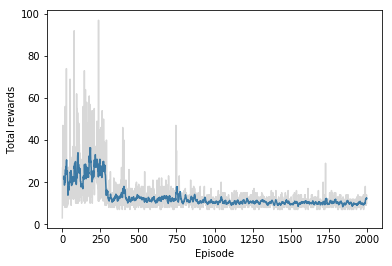

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

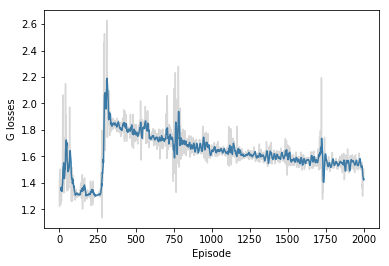

In [21]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

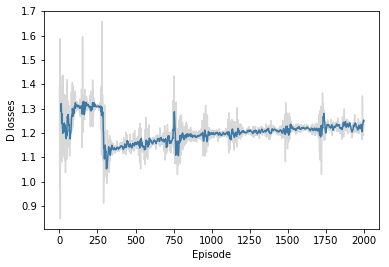

In [22]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.